# CS4243 Captcha Recognition Project

## Import

In [1]:
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, preprocessing, callbacks, Sequential

## Config

In [2]:
## Config
DATA_PATH = os.path.join(os.getcwd(), 'data')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'test')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train')
PREPROCESSED_DATA_PATH = os.path.join(DATA_PATH, 'preprocessed')
PREPROCESSED_TRAIN_DATA_PATH = os.path.join(PREPROCESSED_DATA_PATH, 'train')
PREPROCESSED_TEST_DATA_PATH = os.path.join(PREPROCESSED_DATA_PATH, 'test')
SAMPLE_DATA = 'zzqtgk-0.png'

IMAGE_SHAPE = (128, 64) # (width, height)
IMG_WIDTH, IMG_HEIGHT = IMAGE_SHAPE

BATCH_SIZE = 32
CHARACTERS = '0123456789abcdefghijklmnopqrstuvwxyz'
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARACTERS)}
MAX_LENGTH = 8 # determined from data labels

In [10]:
# Mapping Chars to Nums
char_to_num = layers.StringLookup(vocabulary=list(CHARACTERS), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

print(f"Vocab: {char_to_num.get_vocabulary()}")

Vocab: ['[UNK]', np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z')]


## Preprocess images and save

Running the function with the given dataset gives the following results

Average image size in training data: 459.57 x 80.00

Minimum image size in training data: 140.00 x 80.00

Maximum image size in training data: 780.00 x 80.00

Median image size in training data: 460.00 x 80.00

Mode image size in training data: 500.00 x 80.00


In [3]:
# read all images and determine the average size

def get_image_sizes(data_path):
    """Reads images from a directory and returns a list of their sizes."""
    image_sizes = []
    for filename in os.listdir(data_path):
        img_path = os.path.join(data_path, filename)
        print(f"reading {filename}")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_sizes.append(img.shape)
    return image_sizes

## uncomment to run (long runtime. only used once to determine average)
# train_image_sizes = get_image_sizes(TRAIN_DATA_PATH)
# avg_height = np.mean([size[0] for size in train_image_sizes])
# avg_width = np.mean([size[1] for size in train_image_sizes])
# print(f"Average image size in training data: {avg_width:.2f} x {avg_height:.2f}")

# min_height = np.min([size[0] for size in train_image_sizes])
# min_width = np.min([size[1] for size in train_image_sizes])
# print(f"Minimum image size in training data: {min_width:.2f} x {min_height:.2f}")

# max_height = np.max([size[0] for size in train_image_sizes])
# max_width = np.max([size[1] for size in train_image_sizes])
# print(f"Maximum image size in training data: {max_width:.2f} x {max_height:.2f}")

# median_height = np.median([size[0] for size in train_image_sizes])
# median_width = np.median([size[1] for size in train_image_sizes])
# print(f"Median image size in training data: {median_width:.2f} x {median_height:.2f}")

# mode_height = np.argmax(np.bincount([size[0] for size in train_image_sizes]))
# mode_width = np.argmax(np.bincount([size[1] for size in train_image_sizes]))
# print(f"Mode image size in training data: {mode_width:.2f} x {mode_height:.2f}")

In [6]:
# Function to preprocess an image
def resize_image(img_path, img_shape):
    """Reads an image, resizes it, and normalizes pixel values."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_shape)  # Resize image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (grayscale)
    return img

def preprocess_main(data_path, img_shape, save_path):
    """Preprocesses all images in a directory and saves them."""
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"created {save_path}")

    for filename in os.listdir(data_path):
        img_path = os.path.join(data_path, filename)
        print(f"resizing {filename}")
        img = resize_image(img_path, img_shape)
        ## save as png
        cv2.imwrite(os.path.join(save_path, filename), img)

        ## save as npy for faster datapipe line once preprocessing steps confirmed
        # np.save(os.path.join(PREPROCESSED_DATA_PATH, filename.replace('.png', '.npy')), img)

preprocess_main(TRAIN_DATA_PATH, IMAGE_SHAPE, PREPROCESSED_TRAIN_DATA_PATH)
preprocess_main(TEST_DATA_PATH, IMAGE_SHAPE, PREPROCESSED_TEST_DATA_PATH)

created d:\cs4243\data\preprocessed\train
resizing 0024miih-0.png
resizing 002k-0.png
resizing 006aguv-0.png
resizing 00fh-0.png
resizing 00hai-0.png
resizing 00hgi3n7-0.png
resizing 00o47-0.png
resizing 00wi5-0.png
resizing 010b-0.png
resizing 010ud-0.png
resizing 018l-0.png
resizing 01gokr0s-0.png
resizing 01hmm-0.png
resizing 026hn-0.png
resizing 02748-0.png
resizing 0277g27-0.png
resizing 02cc-0.png
resizing 02d69zs0-0.png
resizing 02tkd-0.png
resizing 03518k9-0.png
resizing 03mxgd-0.png
resizing 03vbk-0.png
resizing 03ykb47u-0.png
resizing 049e-0.png
resizing 04eli6gc-0.png
resizing 04qpex-0.png
resizing 04ue-0.png
resizing 04yh1rvu-0.png
resizing 052s999y-0.png
resizing 053e-0.png
resizing 057ea-0.png
resizing 05h9r3yv-0.png
resizing 05u5elo-0.png
resizing 06mhii9s-0.png
resizing 06rh65-0.png
resizing 06tjxmvu-0.png
resizing 06w6m8y-0.png
resizing 06wtljp-0.png
resizing 06xg-0.png
resizing 06y962-0.png
resizing 06yx8nkv-0.png
resizing 072dg-0.png
resizing 079b8gc-0.png
resizing 0

## Modelling

### Load Data

Use tf.data to create data pipeline using generator so that images need not be read all at once into memory which is too large (8000 images)

In [7]:
# Custom train test split since data is already divided
def get_train_test():
    X_train, X_test, y_train, y_test = [], [], [], []
    for img in os.listdir(PREPROCESSED_TRAIN_DATA_PATH):
        X_train.append(os.path.join(PREPROCESSED_TRAIN_DATA_PATH, img))
        y_train.append(img[:-6].lower())

    for img in os.listdir(PREPROCESSED_TEST_DATA_PATH):
        X_test.append(os.path.join(PREPROCESSED_TEST_DATA_PATH, img))
        y_test.append(img[:-6].lower())

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test()
print(X_train[:5])
print(y_train[:5])

['d:\\cs4243\\data\\preprocessed\\train\\0024miih-0.png', 'd:\\cs4243\\data\\preprocessed\\train\\002k-0.png', 'd:\\cs4243\\data\\preprocessed\\train\\006aguv-0.png', 'd:\\cs4243\\data\\preprocessed\\train\\00fh-0.png', 'd:\\cs4243\\data\\preprocessed\\train\\00hai-0.png']
['0024miih', '002k', '006aguv', '00fh', '00hai']


In [8]:
# Training & Testing Dataset
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
def preprocess(image_path, label):
    # Load image from image path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image/255.
    image = tf.cast(image, tf.float32)

    # Convert label to numerical label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.pad(label, [[0, MAX_LENGTH - tf.shape(label)[0]]], constant_values=0)

    return {"ImageInput":image, "LabelInput":label}

# Apply the preprocessing function
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

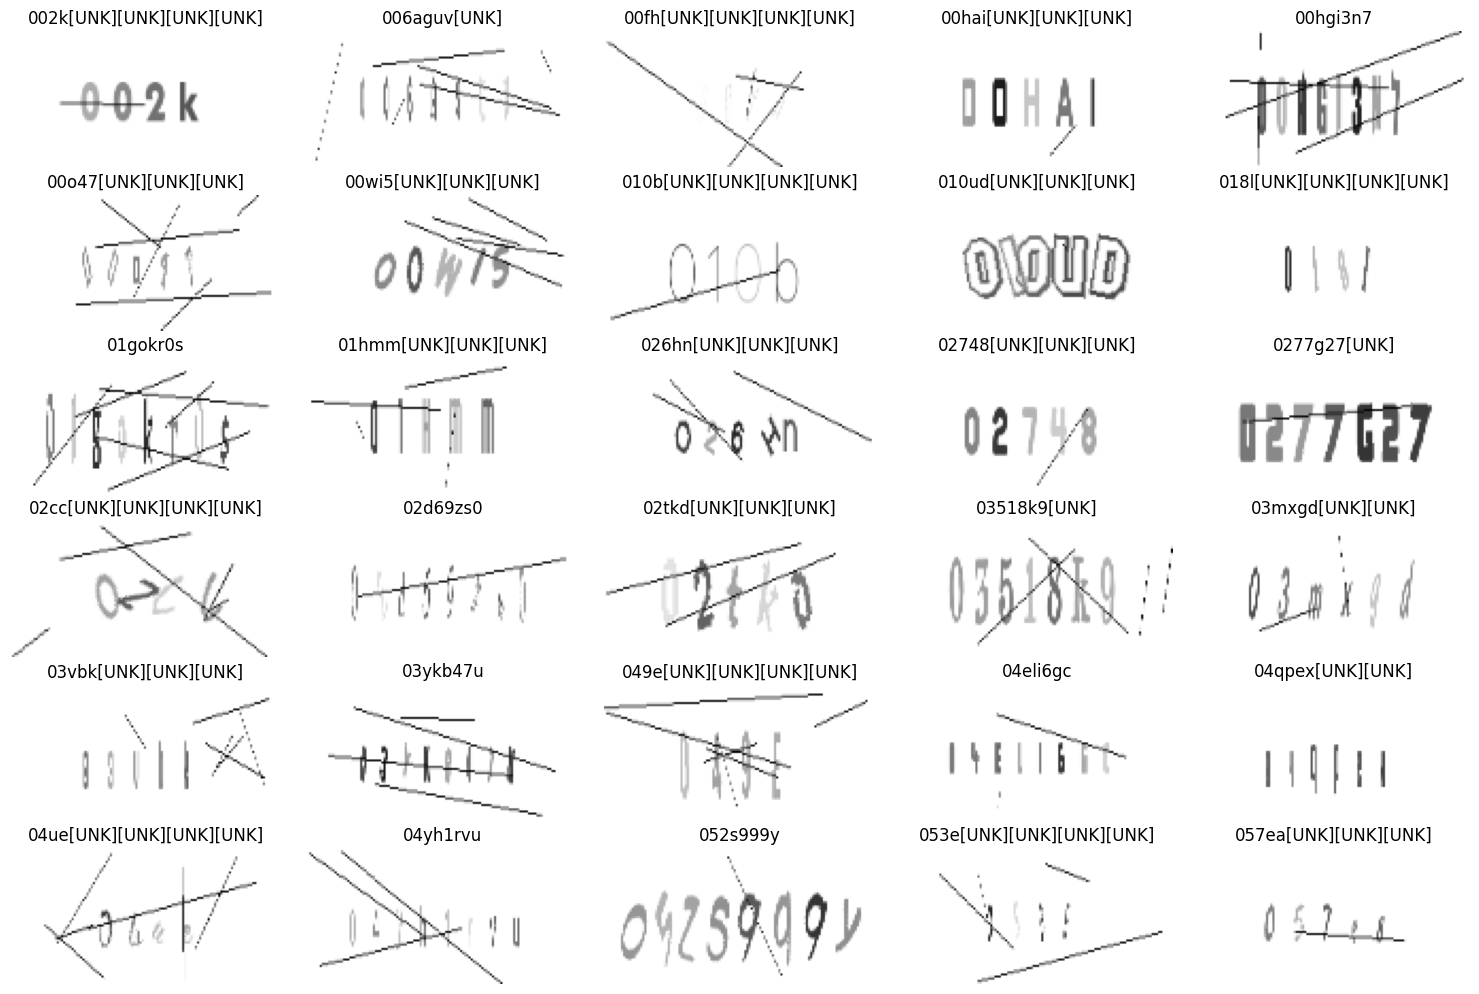

In [12]:
# Loop over images
plt.figure(figsize=(15, 10))

# Select a set of images
data = next(iter(train_ds.batch(BATCH_SIZE)))
images, labels = data['ImageInput'], data['LabelInput']

# Loop over the subset
for index in range(1, 31):

    # Extract info
    image = images[index]
    text_label = tf.strings.reduce_join(num_to_char(labels[index])).numpy().decode("utf-8")

    # Plot the subplot
    plt.subplot(6, 5, index)
    plt.imshow(image)
    plt.title(text_label)
    plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()

In [13]:
# Final process
train_ds = train_ds.repeat(5).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

### Define model architecture

In [14]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ctc_batch_loss = K.ctc_batch_cost

    def call(self, true, pred):

        batch_size = tf.cast(
            tf.shape(true)[0],
            dtype='int64'
        )

        input_length = tf.cast(
            tf.shape(pred)[1],
            dtype='int64'
        )

        output_length = tf.cast(
            tf.shape(true)[1],
            dtype='int64'
        )

        input_length *= tf.ones(shape=(batch_size, 1), dtype='int64')
        output_length *= tf.ones(shape=(batch_size, 1), dtype='int64')

        loss = self.ctc_batch_loss(true, pred, input_length, output_length)
        self.add_loss(loss)

        return pred

In [15]:
# CNN Encoder
encoder = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32'),
    layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer1"
    ),
    layers.MaxPool2D(name="MaxPoolLayer1"),
    layers.Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer2"
    ),
    layers.MaxPool2D(name="MaxPoolLayer2"),
    layers.Reshape(target_shape=(IMG_WIDTH//4, (IMG_HEIGHT//4)*64), name="ReshapeEmbedding"),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', name="ImageEmbeding")

], name="CNN-Encoder")

In [16]:
# LSTM Decoder
decoder = Sequential([
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer1"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer2"),
], name="LSTM-Decoder")

In [17]:
# Input layers for the Image and Label input
image_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32', name="ImageInput")
label_input = layers.Input(shape=(None, ), dtype='float32', name="LabelInput")

# Encoder & decoder network
embeddings = encoder(image_input)
dropout = layers.Dropout(0.5, name="EmbeddingDropout")(embeddings)
output_seq = decoder(dropout)
output_seq = layers.Dense(units=len(char_to_num.get_vocabulary()) + 1, activation='softmax', name="OutputSequence")(output_seq)

# CTC Loss Layer
ctc_loss = CTCLayer(name="CTCLoss")(label_input, output_seq)

# CTC Model
ctc_model = models.Model(
    inputs=[image_input, label_input],
    outputs=[ctc_loss],
    name="CTCModel"
)

# Model Architecture Summary
ctc_model.summary()

Model: "CTCModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ImageInput          │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN-Encoder         │ (None, 32, 64)    │     84,992 │ ImageInput[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingDropout    │ (None, 32, 64)    │          0 │ CNN-Encoder[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM-Decoder        │ (None, 32, 64)    │     49,664 │ EmbeddingDropout… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LabelInput          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ OutputSequence      │ (None, 32, 38)    │      2,470 │ LSTM-Decoder[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CTCLoss (CTCLayer)  │ (None, 32, 38)    │          0 │ LabelInput[0][0], │
│                     │                   │            │ OutputSequence[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 137,126 (535.65 KB)

 Trainable params: 137,126 (535.65 KB)

 Non-trainable params: 0 (0.00 B)

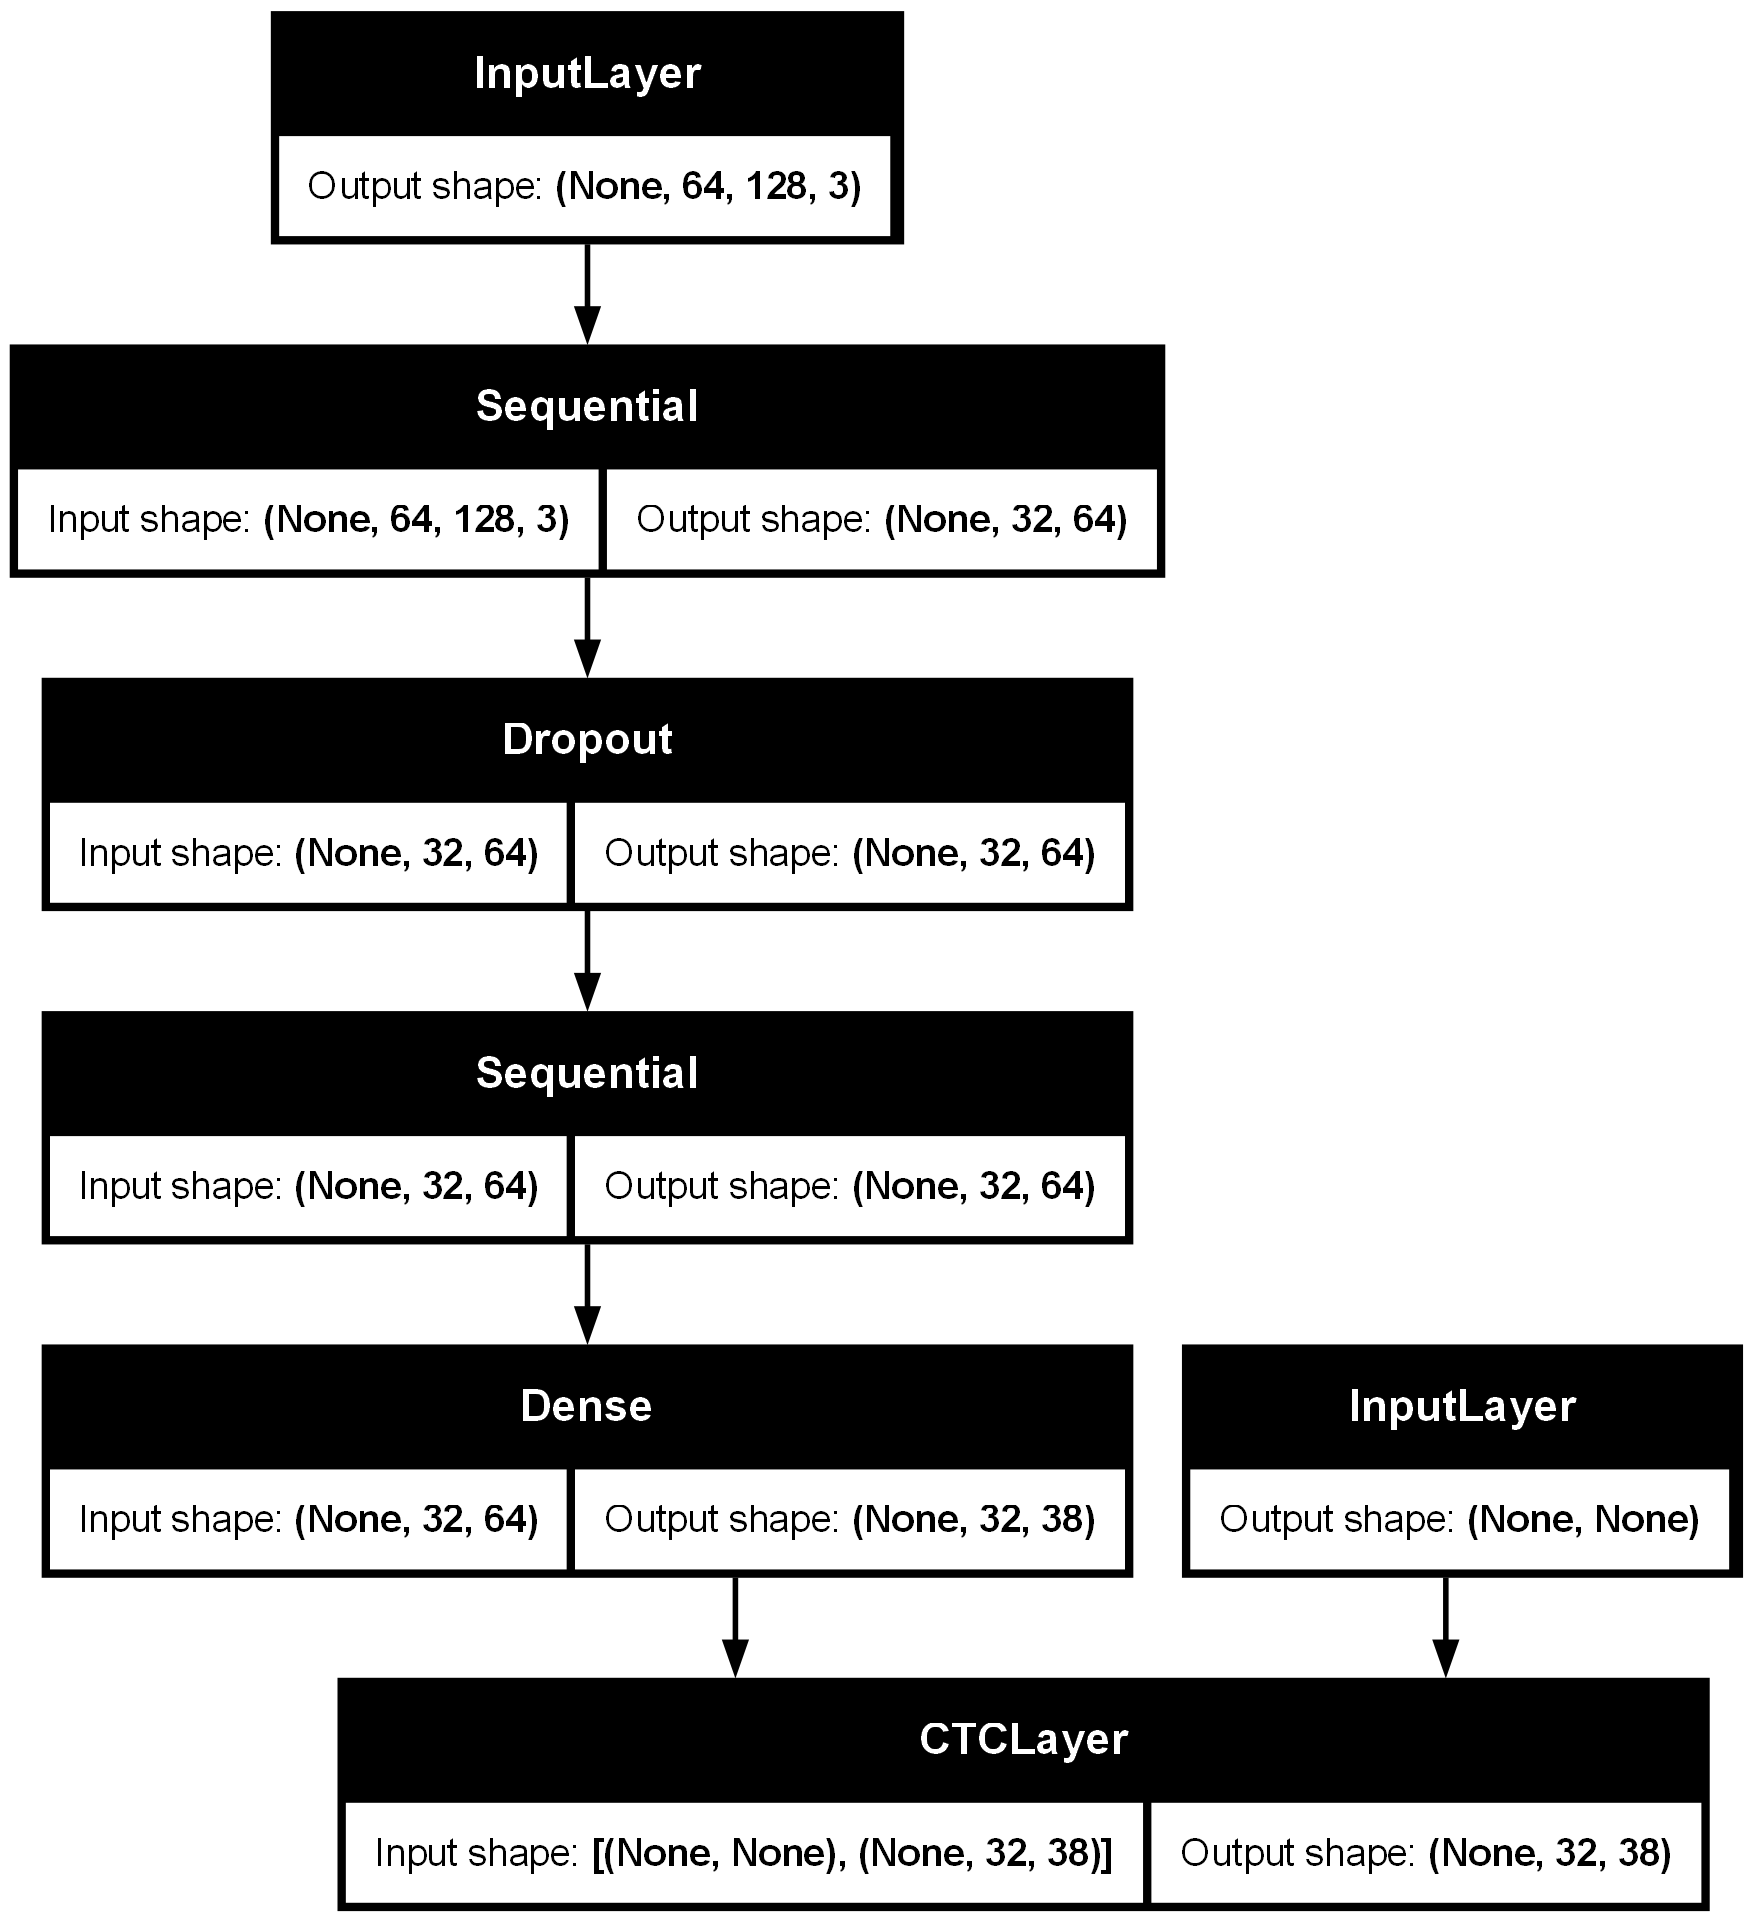

In [18]:
# Model Visualization
keras.utils.plot_model(
    ctc_model,
    to_file="CTCModel.png",
    show_shapes=True,
)

### Train

In [19]:
# Model Compilation
ctc_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3
)
# checkpoint_model = keras.callbacks.ModelCheckpoint(
#     filepath=DATA_PATH + '/model.keras',
#     save_best_only=True,
#     verbose=1
# )

# Model training
history = ctc_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=100,
    callbacks=[
        early_stopping,
        lr_scheduler
    ]
)

Epoch 1/100


C:\Users\LZY_R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ImageInput', 'LabelInput']. Received: the structure of inputs={'ImageInput': '*', 'LabelInput': '*'}
  warnings.warn(


 193/1252 ━━━━━━━━━━━━━━━━━━━━ 2:06 120ms/step - loss: 1236.7853

InvalidArgumentError: Graph execution error:

Detected at node Pad defined at (most recent call last):
<stack traces unavailable>
Error in user-defined function passed to ParallelMapDatasetV2:2 transformation with iterator: Iterator::Root::Prefetch::MemoryCacheImpl::BatchV2::Shuffle::FiniteRepeat[0]::ParallelMapV2: Paddings must be non-negative: 0 -1
	 [[{{node Pad}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_10016]

In [ ]:
## save model
ctc_model.save(DATA_PATH + '/model.keras')

In [ ]:
# Convert to a DataFrame
history_df = pd.DataFrame(history.history)

# Visualize the History
import plotly.express as px
fig = px.line(history_df, y=["loss", "val_loss"], title="Learning Curve")
fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title="Sparse Categorical Crossentropy",
)
fig.show()

### Evaluation

In [ ]:
testing_loss = ctc_model.evaluate(test_ds,  verbose=0)
print(f"Model Testing Loss: {testing_loss}")

Model Testing Loss: 743.8302001953125


In [ ]:
# Define input and output tensors
image_input_tensor = ctc_model.inputs[0]
output_sequence_tensor = ctc_model.get_layer("OutputSequence").output

# Create the prediction model using input and output tensors
ocr_pred_model = keras.Model(inputs=image_input_tensor, outputs=output_sequence_tensor)
ocr_pred_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ImageInput (InputLayer)              │ (None, 64, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CNN-Encoder (Sequential)             │ (None, 32, 64)              │          84,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ EmbeddingDropout (Dropout)           │ (None, 32, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM-Decoder (Sequential)            │ (None, 32, 64)              │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputSequence (Dense)               │ (None, 32, 38)              │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,126 (535.65 KB)

 Trainable params: 137,126 (535.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def decode_prediction(model_pred_seq):

    # Compute the Input length
    input_length = np.ones(model_pred_seq.shape[0]) * model_pred_seq.shape[1]

    # Decode the model predictions (& select the required stuff)
    decode = tf.squeeze(keras.backend.ctc_decode(model_pred_seq, input_length=input_length, greedy=True)[0])

    # Conver the numbers to their respective characters
    decoded_text = [tf.strings.reduce_join(num_to_char(nums)) for nums in decode]

    # Convert thode characters back to a normal string
    decoded_text = [text.numpy().decode().replace('[UNK]', '') for text in decoded_text]

    return decoded_text

['m', 'm1', 'zny', 'cxy', 'hp', 'zn', 'zy', 'zi', 'z1y', 'mi', 'mn', 'm', 'm1', 'hy', 'zzqy', '6qy', 'i', 'hp', 'mn', 'm', 'mn', 'cx', 'cx', 'zy', 'mi', 'hp', 'hp', 'm1', 'ii', 'cqy', 'zy', 'mr']


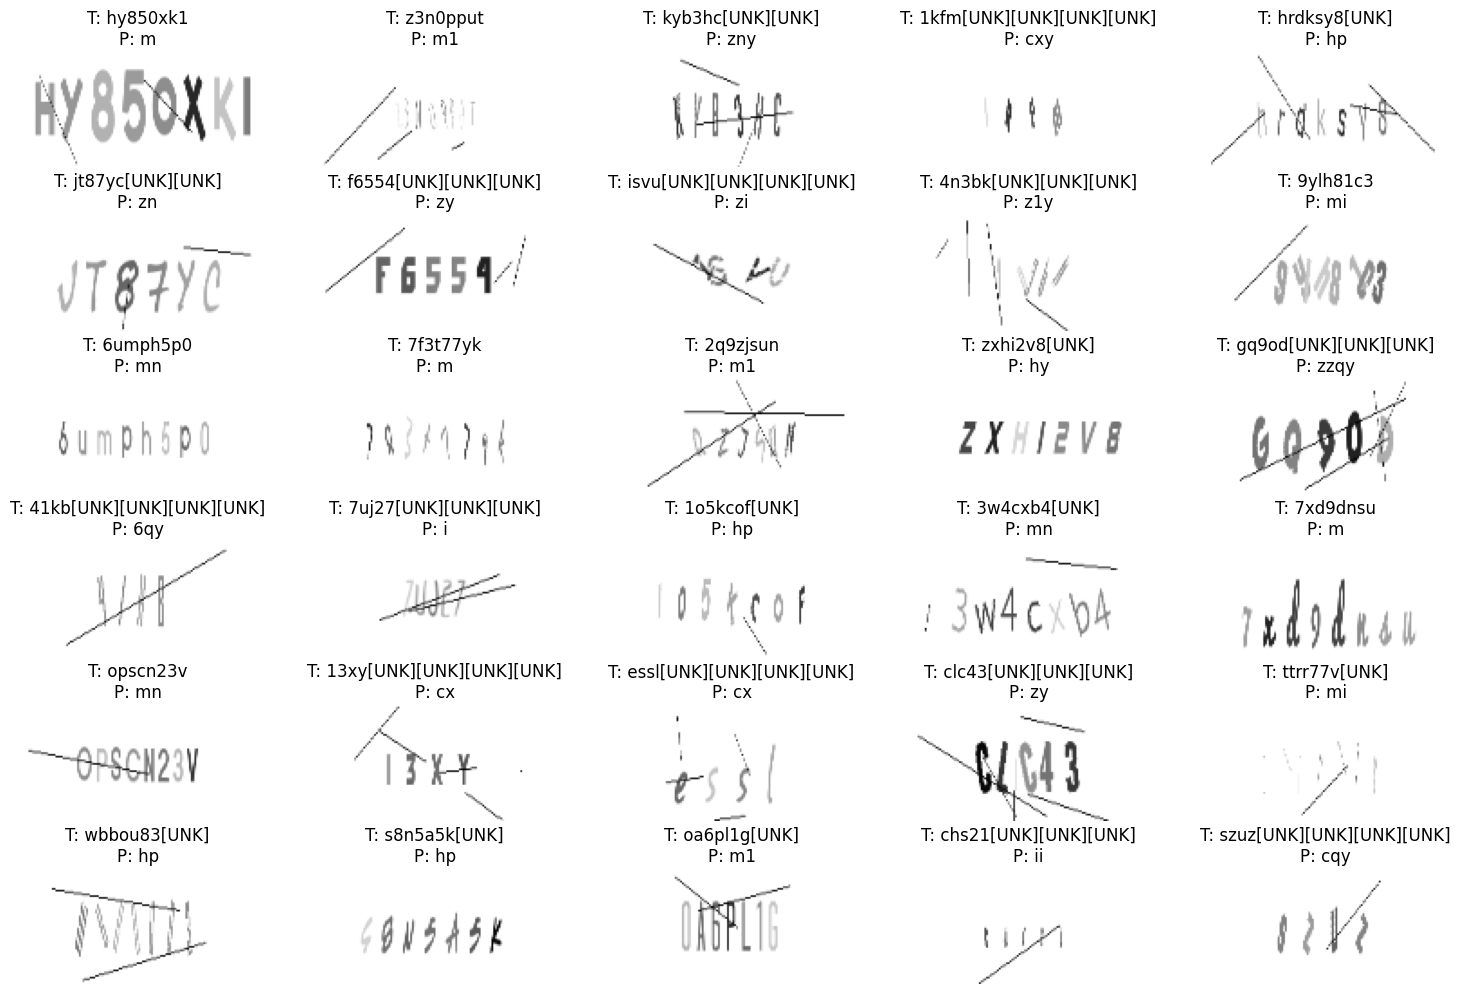

In [ ]:
# Initialize Figure Size
plt.figure(figsize=(15, 10))

# Loop over a subset of images in the dataset
for data in test_ds.take(1):

    # Loop over individual images and labels
    images = data['ImageInput']
    labels = data['LabelInput']
    model_preds = decode_prediction(ocr_pred_model.predict(images, verbose=0))
    print(model_preds)

    for index in range(min(30, len(images))):

        # Extract info for each image and label
        image = images[index]
        true_label = labels[index]
        pred_label = model_preds[index]

        # Decode labels from numerical to text
        true_text = tf.strings.reduce_join(num_to_char(true_label)).numpy().decode("utf-8")

        # Plot the subplot
        plt.subplot(6, 5, index + 1)
        plt.imshow(image)  # Assuming images are grayscale
        plt.title(f'T: {true_text}\nP: {pred_label}')
        plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()


In [ ]:
## Custom captcha accuracy
y_pred_full = ctc_model.predict(test_ds, verbose=0)
y_pred_full = decode_prediction(y_pred_full)

y_true_full = []
for data in test_ds:
    # Append the 'LabelInput' to y_true_full list
    y_true_full.extend(data['LabelInput'].numpy())

# Convert the list of tensors into a single NumPy array
y_true_full = np.array(y_true_full)
y_true_full = [tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8") for label in y_true_full]

def captcha_accuracy(y_true, y_pred):
    total_chars = 0
    correct_chars = 0
    total_words = len(y_true)
    correct_words = 0

    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            correct_chars += len(true_label)
            correct_words += 1
        else:
            correct_chars += len(set(true_label) & set(pred_label))
        total_chars += len(true_label)

    print(f"Correct: {correct_chars}")
    print(f"Total: {total_chars}")
    print(f"Correct: {correct_words}")
    print(f"Total: {total_words}")
    return correct_chars / total_chars, correct_words / total_words

char_accuracy, word_accuracy = captcha_accuracy(y_true_full, y_pred_full)
print(f"Character Accuracy: {char_accuracy}")
print(f"Word Accuracy: {word_accuracy}")

Correct: 644
Total: 31680
Correct: 0
Total: 1984
Character Accuracy: 0.020328282828282827
Word Accuracy: 0.0
